# 3D CNN using Autogrid Results - Data Augmentation 
- $X$: 3D autogrid `.npy` pocket of each conformation
- $y$: performance value of each conformation

### Read the data from drive

In [ ]:
# Mount the drive device to access the dk files
from google.colab import drive

drive.mount('/content/gdrive/')
root_path = '/content/gdrive/My Drive/Doctorado/Pockets_CNN/'
%cd $root_path/
# %ls -lh

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/Doctorado/Pockets_CNN


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='talk', 
        palette='Spectral', font_scale=0.9)

In [ ]:
%%capture
# Instala la librería visualkeras que permite visualizar la arquitectura de la red
!pip install git+https://github.com/paulgavrikov/visualkeras
import visualkeras

### Response Variable $y$
- The **response variable** $y$ will be any of the performance values achieved by each protein conformation after docking. 
- **1,200 molecules from the DEKOIS 2.0** dataset were docked against each protein conformation.
- **1,524 protein conformations** were used for this analysis.

In [ ]:
# First read the information related to each protein conformation
y_full_df = pd.read_pickle('./y_CONFS_PERFORMANCES_vinardo_16_DEKOIS2_R1.pkl')

print('Number of protein conformations:', y_full_df.shape[0])

y_full_df.head()

Number of protein conformations: 1524


ROC AUC     EF  BEDROC  PR AUC
CRYS 1aq1    0.729  0.125   0.168   0.076
     1b38    0.676  0.025   0.061   0.051
     1b39    0.691  0.025   0.075   0.060
     1buh    0.688  0.050   0.078   0.055
     1ckp    0.720  0.050   0.109   0.069

### Define the labels
For the first analysis we will use AUC-ROC values as the response variable.

- <font color='#E22921' size='5'><code>**DRUGGABLE**</code></font> conformation:
  - AUC-ROC > 0.7: Conformations with AUC-ROC values above 0.7

- <font color='#EE9B00' size='5'><code>**NEGATIVE**</code></font> conformation:
  - AUC-ROC <= 0.7

In [ ]:
MODE        = 'CLASS'
target_name = 'ROC AUC'
cutoff = 0.7 

# Data Type
# `POVME`, `AUTOGRID`, `POVME+AUTOGRID`
voxels_type = 'POVME+AUTOGRID'

ROTATE_VAL, ROTATE_TEST = True, True
DO_TRAIN_AUGMENT        = True

In [ ]:
# Create the response variable for a classification task
# We will use the ROC_AUC and a threshold of 0.7
mask = y_full_df.loc[:, target_name] > cutoff
y_true = mask

$R_a$ value: Proportion of DRUGABLE conformations.

In [ ]:
print('Full set:', f'{y_true.sum()}/{len(y_true)} => ', 
                   f'R_a: {y_true.sum()/len(y_true):.2f}')

Full set: 323/1524 =>  R_a: 0.21


## First trial
### Load the pocket Autogrid representations
- For each type of protein conformations, namely `CRYS`, `MIN_CRYS`, etc., load the numpy `.npy` files containing the POVME representation of the pockets.
- **First, we will only use the `volume.npy` files**
- We will load all channels:

```python
atom_types = ['A', 'C', 'HD', 'N', 'NA', 'OA', 'SA', 'P', 'Cl', 'e', 'd']
```

In [ ]:
# For Autogrid we will firt try using a sigmoid normalization
def sigmoid(x: np.array):
    '''A simple sigmoid function'''
    sig = 1 / (1 + np.exp( -x))
    return sig

#### Autogrid Voxels

In [ ]:
# Get the npy files from the four sets in the same order as the y variable
# We will use the atom type npy files
MAP_TYPE_DIR = './autogrid_voxels_24x24x24_atom_types/'
atom_types = ['A', 'C', 'HD', 'N', 'NA', 'OA', 'SA', 'P', 'Cl', 'e', 'd']

def get_autogrid_voxels(atom_types, 
                        MAP_TYPE_DIR = MAP_TYPE_DIR, 
                        trans_sigmoid = True):
  n_channels = len(atom_types)
  channels = {}

  for at in atom_types:
    npy_files = {
        'CRYS'    : f'{MAP_TYPE_DIR}/cdk2_CRYS_voxels_autogrid_{at}.npy',
        'MIN_CRYS': f'{MAP_TYPE_DIR}/cdk2_MINCRYS_voxels_autogrid_{at}.npy',
        'MD'      : f'{MAP_TYPE_DIR}/cdk2_DM-Kms30-pisani_voxels_autogrid_{at}.npy',
        'MIN_MD'  : f'{MAP_TYPE_DIR}/cdk2_MINDM-Kms30-pisani_voxels_autogrid_{at}.npy',
    }
    # Load and concat the files
    X_chan = np.concatenate([np.load(i) for i in npy_files.values()])
    channels[at] = X_chan.astype(np.float32)

  # AUTOGRID
  # Stack all channels
  X_agd = np.stack(list(channels.values()), 
              axis = -1)
  if trans_sigmoid:
    X_agd = sigmoid(X_agd)
  return X_agd

#### POVME Voxels

In [ ]:
def get_povme_voxels(colors):
  pov_colors = {}

  for color in colors:
    npy_files = {
        'CRYS'    : f'cdk2_CRYS_OUT_volxels_povme{color}.npy',
        'MIN_CRYS': f'cdk2_MINCRYS_OUT_volxels_povme{color}.npy',
        'MD'      : f'cdk2_DM-Kms30-pisani_OUT_volxels_povme{color}.npy',
        'MIN_MD'  : f'cdk2_MINDM-Kms30-pisani_OUT_volxels_povme{color}.npy',
    }
    # Load and concat the files
    X_ = np.concatenate([np.load(i) for i in npy_files.values()])
    pov_colors[color] = X_.astype(np.float32)

  # POVME
  X_pov = np.stack(list(pov_colors.values()), 
              axis = -1)
  return X_pov

## Get Voxels => `X` variable

In [ ]:


# FOR AUTOGRID
# Let's start using only a subset of channels
atom_types = ['A', 'HD', 'OA', 'e', 'd']

# FOR POVME
# Load povme results
colors = ['', 
          '_hydrophilic', 
          '_hydrophobic', 
          '_hbondDonor', 
          '_hbondAcceptor', 
          '_aromatic'
          ]

if voxels_type == 'POVME':
  X = get_povme_voxels(colors)
  channel_labels = colors
elif voxels_type == 'AUTOGRID':
  X = get_autogrid_voxels(atom_types)
  channel_labels = atom_types
elif voxels_type == 'POVME+AUTOGRID':
  X_pov = get_povme_voxels(colors)
  X_pov = (X_pov.sum(axis = -1, 
                     keepdims = True) > 0)\
                      .astype(np.float32)
  X_agd = get_autogrid_voxels(atom_types)
  X = X_pov * X_agd[:, :24, :24, :24, :]
  channel_labels = atom_types

print(X.shape)

# Get the number of channels
n_channels     = X.shape[-1]
channel_labels = channel_labels

(1524, 24, 24, 24, 5)


In [ ]:
# @title Visualize VOXELS pockets
# @markdown `plot_povme_pockets(X, labels, color = 'orange', opacity = 0.5)`
import plotly
import plotly.graph_objects as go

def plot_povme_pockets(X, labels, 
                       color = 'orange', 

                       opacity = 0.5):
  fig = go.Figure()
  s_x, s_y, s_z = X[0].shape

  for pkt in X:
    x, y, z = pkt.nonzero()
    fig.add_trace(
        go.Scatter3d(
          x = x, y = y, z = z,
          mode  = 'markers',
          visible=False,
          marker = dict(
              size    = 5,
              opacity = opacity,
              color   = color
            )
          )
        )
    
  fig.data[0].visible = True

  steps = []
  for i in range(len(fig.data)):
      step = dict(
          method="update",
          args=[{"visible": [False] * len(fig.data)},
                {"title": "Conformación: " + labels[i]}], 
      )
      step["args"][0]["visible"][i] = True 
      steps.append(step)
      

  sliders = [dict(
      active=0,
      currentvalue={"prefix": "Conformación: "},
      pad={"t": 50},
      steps=steps
  )]

  fig.update_layout(
      sliders=sliders,
      scene = dict(
          xaxis = dict(nticks=12, range=[0,s_x]),
          yaxis = dict(nticks=12, range=[0,s_y]),
          zaxis = dict(nticks=12, range=[0,s_z]),
          aspectratio=dict(x=1, y=1, z=1)
        ),
  )

  return fig


def plot_povme_channels(X, labels, 
                      colors, 
                      opacity = 0.5):
  fig = go.Figure()
  s_x, s_y, s_z = X[0].shape

  for pkt, color, label in zip(X, colors, labels):
    x, y, z = pkt.nonzero()
    fig.add_trace(
        go.Scatter3d(
          x = x, y = y, z = z,
          mode  = 'markers',
          # visible=False,
          name = label,
          marker = dict(
              size    = 5,
              opacity = opacity,
              color   = color
            )
          )
    )
  
  fig.update_layout(
      scene = dict(
          xaxis = dict(nticks=12, 
                       backgroundcolor="rgb(243, 245, 245)",
                       gridcolor="#aaaaaa",
                       range=[0,s_x]),
          yaxis = dict(nticks=12, 
                       backgroundcolor="rgb(243, 245, 245)",
                       gridcolor="#aaaaaa",
                       range=[0,s_y]),
          zaxis = dict(nticks=12, 
                       backgroundcolor="rgb(243, 245, 245)",
                       gridcolor="#aaaaaa",
                       range=[0,s_y]),
          aspectratio=dict(x=1, y=1, z=1),
          # bgcolor='grey'
        ),
  )

  return fig

In [ ]:
idx  = 0
test = X[idx]

# for autogrid, lets use a threshold to get binary values
if not voxels_type == 'POVME':
  thr_d, thr_u = 0, 0.5
  test = ((test > thr_d) & (test < thr_u)).astype(np.int)

test    = np.moveaxis(test, -1, 0)
palette = ['#C7CBC3', '#F16144', '#1CB5C1',
           '#EEA93F', '#74EE87', 'orange', 'magenta']
fig = plot_povme_channels(test, channel_labels, 
                          colors = palette)
# fig.show()

In [ ]:
#@title Desempeño de la red durante el entrenamiento
#@markdown (desplegar para ver el código)
import matplotlib.pyplot as plt
import seaborn as sns

# Calculamos el F1 score a partir de los resultados de Precision y Recall
def get_f1_score(precision_arr, recall_arr):
  epsilon       = 1e-7
  precision_arr = np.array(precision_arr)
  recall_arr    = np.array(recall_arr)
  f1 = (2) * (precision_arr*recall_arr) / \
      (precision_arr + recall_arr + epsilon)
  return f1

def plot_history(train_hist, suptitle=''):
  # Agregar F1 score
  train_hist['F1_score']     = get_f1_score(train_hist['precision'], 
                                    train_hist['recall'])
  train_hist['val_F1_score'] = get_f1_score(train_hist['val_precision'], 
                                    train_hist['val_recall'])

  # Gráficas
  metrics = [key for key in train_hist.keys() 
              if not key.startswith('val')]
  metrics.remove('recall')        

  fig, ax = plt.subplots(2, int(len(metrics)/2), 
                        figsize = (16, 8))
  for i, metric in enumerate(metrics):
    if i < 3: 
      j = 0
    else: 
      i, j = i - 3, 1
    ax[j, i].plot(train_hist[metric])
    ax[j, i].plot(train_hist[f"val_{metric}"])
    ax[j, i].set_title(metric.replace('_', ' ').capitalize())
    ax[j, i].set_xlabel('Épocas')
    ax[j, i].grid()
    if metric != 'loss':
      ax[j, i].set_ylim(0.0, 1.05)
      if metric == 'roc_auc':
        ax[j, i].set_ylim(0.4, 1.05)
    else:
      ax[j, i].legend(['Train', 'Val'])
  plt.tight_layout(2)
  plt.suptitle(suptitle, y = 1.02)
  plt.show()

In [ ]:
#@title Función para calcular la matriz de confusión
#@markdown (desplegar para ver el código)

from sklearn.metrics import confusion_matrix

def plot_cfn_matrix(y_test, y_pred_classes, suptitle=''):
  cf_matrix = confusion_matrix(y_test, y_pred_classes)

  labels_a = np.array(
      [f'{i}\n{j}' 
      for i, j in
        zip(['TN', 'FP', 'FN', 'TP'],
              cf_matrix.flatten()
          )
      ]).reshape(2,2)

  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  # Valores crudos
  sns.heatmap(cf_matrix, 
              cmap = 'Reds', ax = ax[0], 
              fmt = '', annot = labels_a,
              cbar_kws={'label': 'Imágenes'})
  # Porcentajes
  sns.heatmap(cf_matrix/np.sum(cf_matrix), 
              cmap = 'Blues', ax = ax[1], 
              fmt = '.2%', annot = True,
              cbar_kws={'label': 'Porcentaje'})
  for i in range(2):
    ax[i].set(aspect = "equal", 
              xlabel = 'Predichos', ylabel = 'Reales')
    for _, spine in ax[i].spines.items():
      spine.set_visible(True)
  plt.suptitle(suptitle, y = 1.05)
  plt.tight_layout()

In [ ]:
#@title Curvas ROC y Precision-Recall
#@markdown (desplegar para ver el código)

from sklearn.metrics import roc_auc_score, roc_curve, \
          f1_score, precision_recall_curve, average_precision_score

def plot_roc_and_pr_curves(y_test, y_pred, 
                           suptitle='', name = ''):
  auc_ = roc_auc_score(y_test, y_pred)
  f1_score_ = roc_auc_score(y_test, y_pred)
  vg_pr_score = average_precision_score(y_test, y_pred)

  fpr, tpr, _ = roc_curve(y_test, y_pred)
  prec_, recall_, _ = precision_recall_curve(y_test, y_pred)
  pr_baseline = y_test.sum() / len(y_test)

  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  # Curva ROC
  ax[0].plot(fpr, tpr, c = '#00A3A4', 
            linewidth = 4, label = f'{name}: {auc_:.3f} AUC')
  ax[0].plot([0, 1], [0, 1], c = 'gray',
            linestyle = '--', label = 'Aleatorio')
  ax[0].legend()
  ax[0].set(xlabel = '1 - Especificidad (FPR)',
            ylabel = 'Sensibilidad (TPR)')

  # Curva de Precision-Sensibilidad
  ax[1].plot(recall_, prec_, c = '#F48000', 
            linewidth = 4, label = f'{name}: {vg_pr_score:.3f} avgPR')
  ax[1].plot([0, 1], [pr_baseline, pr_baseline], c = 'gray',
            linestyle = '--', label = 'Aleatorio')
  ax[1].legend()
  ax[1].set(xlabel = 'Sensibilidad',
            ylabel = 'Precisión')
  for i, title in enumerate(['Curva ROC', 
                            'Curva Precisión-Sensibilidad']):
    ax[i].set(aspect='equal', ylim=(0,1.02), title=title)
    ax[i].grid(True)
  plt.tight_layout()
  plt.suptitle(suptitle, y = 1.02)
  plt.show()

## Train-validation-test splitting

In [ ]:
# Create the train-validation-test set
# 70-15-15
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

# Define the train set
X_train, X_temp, y_train, y_temp = train_test_split(X, y_true, 
                                              test_size = 0.3,
                                              stratify = y_true,
                                              random_state = RANDOM_STATE)
# Validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                              test_size = 0.5,
                                              stratify = y_temp,
                                              random_state = RANDOM_STATE)
# Report the R_a values
for i, j in zip(('train', 'test', 'val'), 
                (y_train, y_test, y_val)):
  n = len(j)
  a = j.sum()
  R_a = a / n
  print(f'{i}\t-> n = {n};\t# actives: {a} \t R_a = {R_a:.2f}')

train	-> n = 1066;	# actives: 226 	 R_a = 0.21
test	-> n = 229;	# actives: 48 	 R_a = 0.21
val	-> n = 229;	# actives: 49 	 R_a = 0.21


### Data Augmentation and Training data Expansion
#### Define the transformation function
- The `training` set is augmented/expanded by adding new pockets generated from random rotations of original pockets.
- `test` and `validation` sets are not modified.

In [ ]:
from scipy import ndimage

def scipy_rotate(volume):
        # define some rotation angles
        # angles = [-180, -60, -90, -30, 0, 30, 90, 60, 180]
        angles = [-180, -120, -90, -45, 0, 45, 90, 120, 180]
        # pick angles and plane (axes) randomly
        axes = sorted(np.random.choice([0, 1, 2], 
                                 size = 2, 
                                 replace = False))
        angle = np.random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, 
                                angle = angle,
                                # axes  = axes, 
                                mode = 'constant',
                                order = 0,
                                reshape = False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

@tf.function
def rotate(volume):
    """Rotate the pocket by a some degrees"""

    augmented_volume = tf.numpy_function(scipy_rotate, 
                                         [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by adding a channel."""
    volume = rotate(volume)
    return volume, label

# These are not required now
def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    return volume, label

def test_preprocessing(volume, label):
    """Process test data by only adding a channel."""
    return volume, label

#### Visualize the pockets double check the expansion

In [ ]:
idx    = 0
test   = X_val[idx]
test_r = scipy_rotate(test)
print(test_r.shape, print(test.shape))

# for autogrid, lets use a threshold to get binary values
if not voxels_type == 'POVME':
  thr_d, thr_u = 0, 0.5
  test   = ((test  > thr_d) & (test < thr_u))
  test_r = ((test_r  > thr_d) & (test_r < thr_u))

print(test_r.shape, print(test.shape))

test_r = test_r[:,:,:,0]
test   = test[:,:,:,0]
print(test_r.shape, print(test.shape))


palette = ['#C7CBC3', '#F16144', 
           '#1CB5C1', '#EEA93F']

pockets = np.stack([test, test_r])
fig = plot_povme_pockets(pockets, ['Org', 'Rot'])
# fig.show()

(24, 24, 24, 5)
(24, 24, 24, 5) None
(24, 24, 24, 5)
(24, 24, 24, 5) None
(24, 24, 24)
(24, 24, 24) None


## Augment `X_val`

### Create the datasets using Data Augmentation

- Using the <font color='red'>`X_train`</font> and the <font color='red'>`y_train`</font> sets.

In [ ]:
# Define the data loaders from the original sets

# ***************************************************
#                   DATA LOADERS
# ***************************************************

# *************  Training sets ***************
train_loader = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train.values))

# ************  Val and Test set ***************
if ROTATE_VAL:
  X_val = np.array([scipy_rotate(pkt) for pkt in X_val])
validation_loader = tf.data.Dataset.from_tensor_slices(
    (X_val, y_val.values))

if ROTATE_TEST:
  X_test = np.array([scipy_rotate(pkt) for pkt in X_test])
test_loader = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test.values))


# ***************************************************
#                   DATASETS
# ***************************************************
batch_size = 64

if DO_TRAIN_AUGMENT:
  # With Data Augmentation
  train_dataset = (
      train_loader
        .shuffle(len(X_train))
        .map(train_preprocessing)
        .batch(batch_size)
        .prefetch(2)
  )
else:
  # Without data Augmentation
  train_dataset = (
      train_loader
        .shuffle(len(X_train))
        .batch(batch_size)
        .prefetch(2)
  )

# Only add the channel
val_dataset = (
    validation_loader
      .shuffle(len(X_val))
      # .map(validation_preprocessing)
      .batch(batch_size)
      .prefetch(2)
)
# Only add the channel
test_dataset = (
    test_loader
      # .map(test_preprocessing)
      .batch(batch_size)
      .prefetch(2)
)

#### Sanity check Visualization
Verify that the Rotation is working correctly without interpolation.
- Use `POVME` voxels for a clearer review

In [ ]:
# p1 = X_val_aug[0,:,:,:,0]
# p2 = X_val[0,:,:,:,0]
# p3, lab = list(val_dataset.take(1))[0]
# p3 = p3[0,:,:,:,0]
# print(p1.shape, p2.shape)
# pockets = np.stack([p1, p2, p3])
# fig = plot_povme_pockets(pockets, ['Org', 'Rot', 'p3'])
# fig.show()

## Convolutional Neural Networks

### Define common parameters across the networks

#### Performance metrics

In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy, \
      AUC, Recall, Precision

metrics = [BinaryAccuracy(name = 'accuracy'),
           AUC(name = 'roc_auc'),
           AUC(name='pr_auc', curve='PR'),
           Precision(name = 'precision'),
           Recall(name = 'recall')
           ]

#### Optimizer

In [ ]:
from tensorflow.keras.optimizers import Nadam

learning_rate = 0.0008
optimizer = Nadam(
      learning_rate = learning_rate, 
      beta_1        = 0.9, 
      beta_2        = 0.999, 
      epsilon       = 1e-07,
      name          = 'Nadam'
)

#### Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, \
                                    EarlyStopping, TensorBoard
def restart_callbacks(
    MONITOR  = 'val_loss',
    MODE     = 'min',
    PATIENCE = 20
  ):

  # Early Stopping
  early_stop = EarlyStopping(
      monitor  = MONITOR,
      mode     = MODE,
      patience = PATIENCE,
      verbose = 2
  )

  # ModelCheckpoint
  TEST_NUM = 'T12'
  SUBNAME = "CNN_TESTING" + f"_{MODE}_{target_name.replace(' ', '-')}-{cutoff}"
  model_filepath = f"{root_path}/models/{TEST_NUM}_{SUBNAME}" +  \
                  "_Ep{epoch:04d}_VL{val_loss:.2f}.h5"
                  
  checkpoint = ModelCheckpoint(model_filepath, 
                  monitor        = MONITOR, 
                  mode           = MODE,
                  verbose        = 1, 
                  save_best_only = True,
                  restore_best_weights = True
  )

  # TensorBoard
  tensorboard = TensorBoard(log_dir = f'./logs_{SUBNAME}')

  # Lista de Callbacks
  callbacks_list = [
                    early_stop, 
                    # checkpoint,
                    # tensorboard
                  ]
  return callbacks_list

### Initial Bias

In [ ]:
# bias inicial para la inicialización de los pesos en la capa de salida
initial_bias = np.log([R_a])
output_bias  = tf.keras.initializers.Constant(initial_bias)

In [ ]:
from sklearn.utils import class_weight

c_weights = class_weight.compute_class_weight('balanced',
                                              np.unique(y_train),
                                              y_train)
class_weights = {0: c_weights[0],
                 1: c_weights[1]}
class_weights

total = len(y_train)
pos = y_train.sum()
neg = total - pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}
class_weights

{0: 0.6345238095238096, 1: 2.3584070796460175}

### First Model

- y_true
- Dropout for regularization

In [ ]:
# Define a 3D convolutional network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, InputLayer, ZeroPadding3D,\
                MaxPooling3D, Dropout, Flatten, Dense, AveragePooling3D,\
                BatchNormalization, Activation, LeakyReLU, \
                GlobalAveragePooling3D
from tensorflow.keras.activations import relu

In [ ]:
def get_new_model(input_shape, n_channels = 3):
  model = Sequential()
  model.add(InputLayer(input_shape = input_shape))

  # First stack CNN layer
  model.add(Conv3D(filters    = 32, 
                  kernel_size = 3,
                  activation  = 'relu'
                ))
  # model.add(MaxPooling3D(pool_size = (2, 2, 2)))
  model.add(Conv3D(filters    = 32, 
                  kernel_size = 3,
                  activation  = 'relu'
                  ))
  # model.add(MaxPooling3D(pool_size = (2, 2, 2)))
  model.add(Dropout(rate = 0.3))
  model.add(Conv3D(filters    = 32, 
                  kernel_size = 3,
                  activation  = 'relu',
                  padding = 'same'
                  ))
  model.add(AveragePooling3D(pool_size = (2, 2, 2)))
  model.add(Dropout(rate = 0.3))

  model.add(Conv3D(filters    = 64, 
                  kernel_size = 5,
                  activation  = 'relu'
                  ))
  # model.add(Dropout(rate = 0.2))
  # model.add(Conv3D(filters    = 32, 
  #                 kernel_size = 3,
  #                 activation  = 'relu'
  #                 ))                 
  model.add(MaxPooling3D(pool_size = (2, 2, 2)))
  model.add(Dropout(rate = 0.3))

  # # # Second CNN
  # model.add(Conv3D(filters    = 32, 
  #                 kernel_size = 3,
  #                 activation  = 'relu'
  #                 ))
  # model.add(MaxPooling3D(pool_size = (2, 2, 2)))
  # model.add(Dropout(rate = 0.2))

  # Classification 
  model.add(Flatten())

  model.add(Dense(units = 128, 
                  activation = 'relu'))
  model.add(Dropout(rate = 0.5))

  model.add(Dense(units      = 32, 
                  activation = 'relu'))
  model.add(Dropout(rate = 0.25))
  # model.add(Dense(units      = 16, 
  #                 activation = 'relu'))
  # model.add(Dropout(rate = 0.25))

  # Output layer
  model.add(Dense(units            = 1, 
                  activation       = 'sigmoid'
                  # bias_initializer = output_bias
                  )
            )
  return model

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_117 (Conv3D)          (None, 22, 22, 22, 32)    4352      
_________________________________________________________________
conv3d_118 (Conv3D)          (None, 20, 20, 20, 32)    27680     
_________________________________________________________________
dropout_135 (Dropout)        (None, 20, 20, 20, 32)    0         
_________________________________________________________________
conv3d_119 (Conv3D)          (None, 20, 20, 20, 32)    27680     
_________________________________________________________________
average_pooling3d_19 (Averag (None, 10, 10, 10, 32)    0         
_________________________________________________________________
dropout_136 (Dropout)        (None, 10, 10, 10, 32)    0         
_________________________________________________________________
conv3d_120 (Conv3D)          (None, 6, 6, 6, 64)     

None

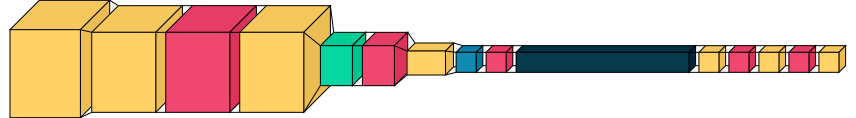

In [ ]:
# Visualize the modeld
model_1 = get_new_model(input_shape = X_train[0].shape, 
                        n_channels = n_channels)
display(model_1.summary())
visualkeras.layered_view(model = model_1, scale_xy = 4)

In [ ]:
print('Target Var', target_name)
print('Voxels type', voxels_type)
print('# Channels', n_channels)
print('AUGMENTATION?', DO_TRAIN_AUGMENT)
print('ROTATED_VAL/TEST', ROTATE_VAL, ROTATE_TEST)

Target Var ROC AUC
Voxels type POVME+AUTOGRID
# Channels 5
AUGMENTATION? True
ROTATED_VAL/TEST True True


In [ ]:
# Callbacks
callbacks_list = restart_callbacks(
    PATIENCE = 20
)

# Compile and train the model
model_1.compile(
    optimizer = optimizer,
    loss      = 'binary_crossentropy',
    metrics   =  metrics
)

BATCH_SIZE = 64
EPOCHS = 100

history_1 = model_1.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs          = EPOCHS, 
    batch_size      = BATCH_SIZE,
    shuffle         = True,
    callbacks       = callbacks_list,
    class_weight    = class_weights
)

Epoch 1/100
17/17 [==============================] - 13s 588ms/step - loss: 0.6984 - accuracy: 0.5300 - roc_auc: 0.4749 - pr_auc: 0.1947 - precision: 0.1780 - recall: 0.3363 - val_loss: 0.6995 - val_accuracy: 0.2140 - val_roc_auc: 0.5000 - val_pr_auc: 0.2140 - val_precision: 0.2140 - val_recall: 1.0000
Epoch 2/100
17/17 [==============================] - 9s 514ms/step - loss: 0.6935 - accuracy: 0.3715 - roc_auc: 0.4973 - pr_auc: 0.2165 - precision: 0.2139 - recall: 0.7345 - val_loss: 0.7001 - val_accuracy: 0.2140 - val_roc_auc: 0.5000 - val_pr_auc: 0.2140 - val_precision: 0.2140 - val_recall: 1.0000
Epoch 3/100
17/17 [==============================] - 9s 510ms/step - loss: 0.6935 - accuracy: 0.3377 - roc_auc: 0.4965 - pr_auc: 0.2096 - precision: 0.2115 - recall: 0.7788 - val_loss: 0.6967 - val_accuracy: 0.2140 - val_roc_auc: 0.5167 - val_pr_auc: 0.2197 - val_precision: 0.2140 - val_recall: 1.0000
Epoch 4/100
17/17 [==============================] - 9s 513ms/step - loss: 0.6938 - accura

In [ ]:
df_res = pd.DataFrame({k: (np.min(v), np.max(v)) 
            for k, v in history_1.history.items()},
            index = ['min', 'max']
             ).round(3).T
print(df_res)
# print('R', df_res.loc['pr_auc', 'max'])

                 min    max
loss           0.500  0.715
accuracy       0.248  0.796
roc_auc        0.462  0.842
pr_auc         0.195  0.635
precision      0.178  0.514
recall         0.336  0.942
val_loss       0.482  0.771
val_accuracy   0.214  0.786
val_roc_auc    0.491  0.823
val_pr_auc     0.206  0.573
val_precision  0.000  0.494
val_recall     0.000  1.000


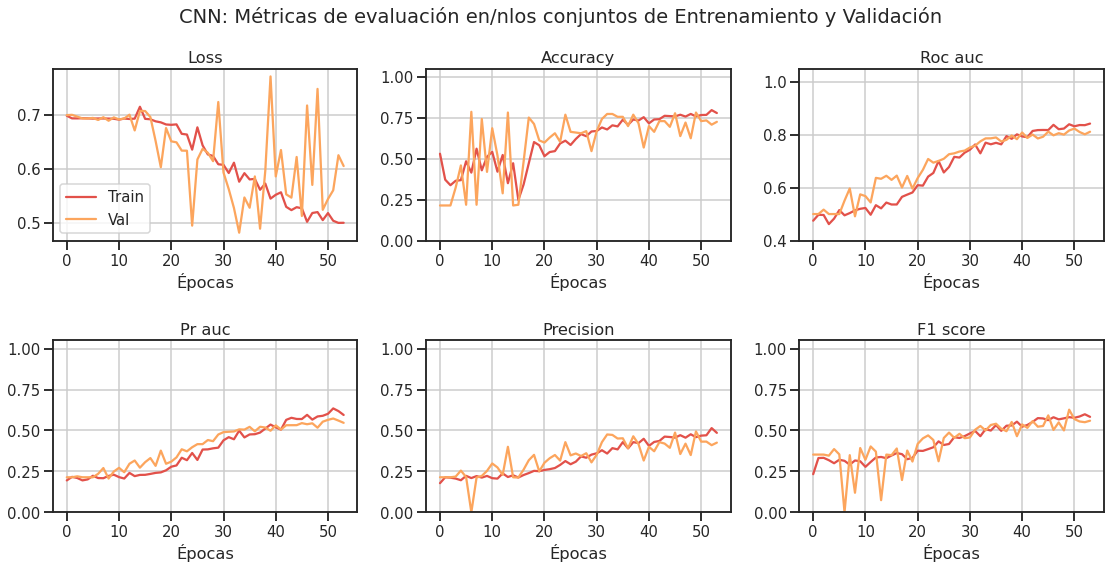

In [ ]:
# Ejecutamos la función
train_hist = history_1.history
plot_history(train_hist, 
      suptitle='CNN: Métricas de evaluación en/n' + 
      'los conjuntos de Entrenamiento y Validación')


In [ ]:
score_test = model_1.evaluate(test_dataset, batch_size=64)

for i, j in zip(history_1.history.keys(), score_test):
  print(f'{i.upper()}: {j:.3f}')
  

4/4 [==============================] - 0s 89ms/step - loss: 0.5209 - accuracy: 0.7729 - roc_auc: 0.8517 - pr_auc: 0.5721 - precision: 0.4744 - recall: 0.7708
LOSS: 0.521
ACCURACY: 0.773
ROC_AUC: 0.852
PR_AUC: 0.572
PRECISION: 0.474
RECALL: 0.771


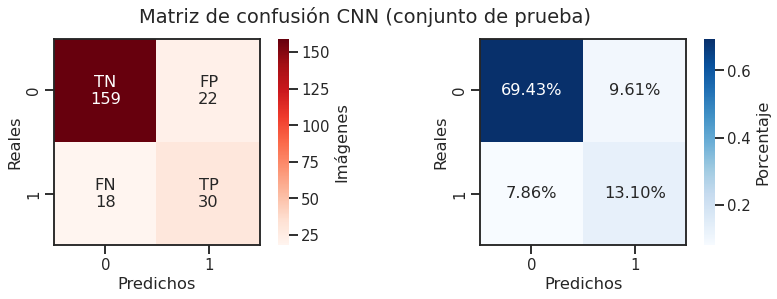

In [ ]:
# Etiquetas reales 
# Predicciones
y_pred = model_1.predict(test_dataset)
y_pred_classes = (y_pred >= 0.7).astype('int32')
# Genera la gráfica
plot_cfn_matrix(y_test, y_pred_classes, 
    suptitle='Matriz de confusión CNN (conjunto de prueba)')

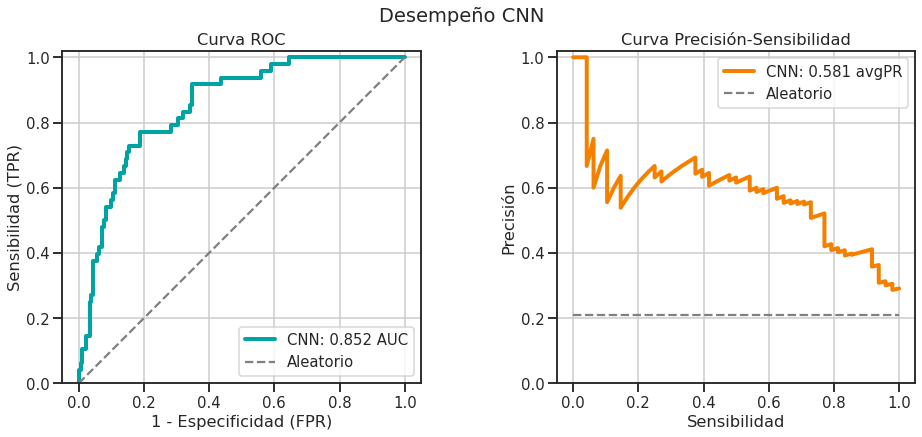

In [ ]:
plot_roc_and_pr_curves(y_test, y_pred, 
          suptitle='Desempeño CNN', name = 'CNN')

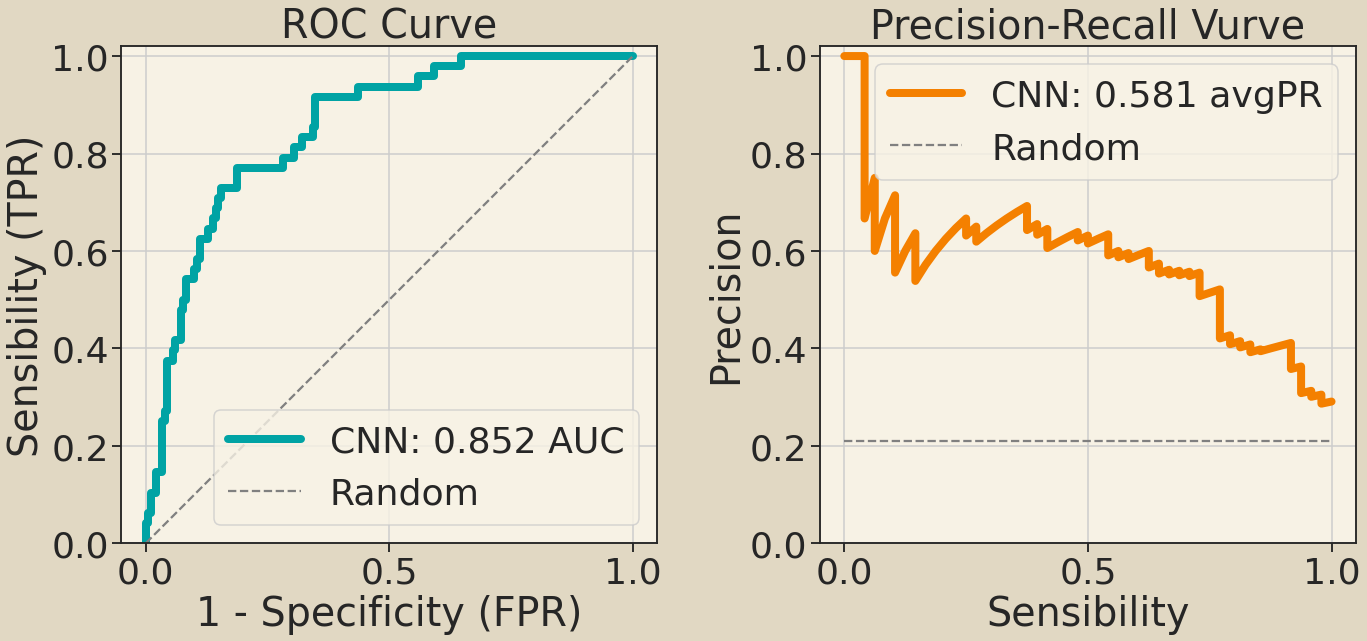

In [ ]:
#@title Curvas ROC y Precision-Recall
#@markdown (desplegar para ver el código)

from sklearn.metrics import roc_auc_score, roc_curve, \
          f1_score, precision_recall_curve, average_precision_score

sns.set(context = 'talk', style = 'ticks', font_scale = 1.4)

sns.set(context='talk', 
        style='ticks', font_scale = 2.2,
        rc={'axes.facecolor':'#F7F2E5', 'figure.facecolor':'#E1D8C3'})

def plot_roc_and_pr_curves(y_test, y_pred, 
                           suptitle='', name = ''):
  auc_ = roc_auc_score(y_test, y_pred)
  f1_score_ = roc_auc_score(y_test, y_pred)
  vg_pr_score = average_precision_score(y_test, y_pred)

  fpr, tpr, _ = roc_curve(y_test, y_pred)
  prec_, recall_, _ = precision_recall_curve(y_test, y_pred)
  pr_baseline = y_test.sum() / len(y_test)

  fig, ax = plt.subplots(1, 2, figsize=(20, 12))

  # Curva ROC
  ax[0].plot(fpr, tpr, c = '#00A3A4', 
            linewidth = 8, label = f'{name}: {auc_:.3f} AUC')
  ax[0].plot([0, 1], [0, 1], c = 'gray',
            linestyle = '--', label = 'Random')
  ax[0].legend()
  ax[0].set(xlabel = '1 - Specificity (FPR)',
            ylabel = 'Sensibility (TPR)')

  # Curva de Precision-Sensibilidad
  ax[1].plot(recall_, prec_, c = '#F48000', 
            linewidth = 8, label = f'{name}: {vg_pr_score:.3f} avgPR')
  ax[1].plot([0, 1], [pr_baseline, pr_baseline], c = 'gray',
            linestyle = '--', label = 'Random')
  ax[1].legend()
  ax[1].set(xlabel = 'Sensibility',
            ylabel = 'Precision')
  for i, title in enumerate(['ROC Curve', 
                            'Precision-Recall Vurve']):
    ax[i].set(aspect='equal', ylim=(0,1.02), title=title)
    ax[i].grid(True)
  plt.tight_layout()
  # plt.suptitle(suptitle, y = 0.92)
  ax[0].patch.set_linewidth('8') 
  ax[1].patch.set_linewidth('4') 
  plt.show()


plot_roc_and_pr_curves(y_test, y_pred, 
          suptitle='CNN Performance (Test set)', name = 'CNN')

# y-scrambling
## New model

In [ ]:
# Perform the permutation 
y_train_scr = np.random.permutation(y_train)
y_val_scr   = np.random.permutation(y_val)
y_test_scr  = np.random.permutation(y_test)

In [ ]:
# Evaluate the permutation sets
for i, j in zip(('train', 'test', 'val'), 
                (y_train_scr, y_test_scr, y_val_scr)):
  n = len(j)
  a = j.sum()
  R_a = a / n
  print(f'{i}\t-> n = {n};\t# actives: {a} \t R_a = {R_a:.2f}')

train	-> n = 1066;	# actives: 226 	 R_a = 0.21
test	-> n = 229;	# actives: 48 	 R_a = 0.21
val	-> n = 229;	# actives: 49 	 R_a = 0.21


### Create the scrambled data sets

In [ ]:
# Define the data loaders from the original sets
train_loader_scr = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train_scr))
validation_loader_scr = tf.data.Dataset.from_tensor_slices(
    (X_val, y_val_scr))
test_loader_scr = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test_scr))

batch_size = 64
# Augment the data on the fly during training.
train_dataset_scr = (
    train_loader_scr.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only add the channel
val_dataset_scr = (
    validation_loader_scr.shuffle(len(X_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only add the channel
test_dataset_scr = (
    test_loader_scr.map(test_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

#### Create the second model

In [ ]:
model_2 = get_new_model()
display(model_2.summary())
visualkeras.layered_view(model = model_2, scale_xy=3)

TypeError: ignored

In [ ]:
# Compile and train the model
model_2.compile(
    optimizer = optimizer,
    loss      = 'binary_crossentropy',
    metrics   = metrics
)

BATCH_SIZE = 64
EPOCHS = 50

history_2 = model_2.fit(
    train_dataset_scr,                  # SCRAMBLED
    validation_data = val_dataset_scr,  # SCRAMBLED
    epochs          = EPOCHS, 
    batch_size      = BATCH_SIZE,
    shuffle         = True,
    callbacks       = callbacks_list
)

In [ ]:
# Ejecutamos la función
train_hist_2 = history_2.history
plot_history(train_hist_2, 
      suptitle='y-scrambling -> CNN: Métricas de evaluación en/n' + 
      'los conjuntos de Entrenamiento y Validación')

In [ ]:
# ORIGINAL test set
print('Predictions on the ORIGINAL test set:')
score_test = model_2.evaluate(test_dataset, batch_size=64)

for i, j in zip(history_2.history.keys(), score_test):
  print(f'{i.upper()}: {j:.3f}')

In [ ]:
# SCRAMBLED test set
print('Predictions on the SCRAMBLED test set:')
score_test = model_2.evaluate(test_dataset_scr, batch_size=64)

for i, j in zip(history_2.history.keys(), score_test):
  print(f'{i.upper()}: {j:.3f}')

In [ ]:
# Etiquetas reales 
# Predicciones
y_pred = model_2.predict(test_dataset)
y_pred_classes = (y_pred >= 0.5).astype('int32')
# Genera la gráfica
plot_cfn_matrix(y_test, y_pred_classes, 
    suptitle='y-scrambling/nMatriz de confusión CNN (conjunto de prueba ORIGINAL)')

plot_roc_and_pr_curves(y_test, y_pred, 
          suptitle='y-scrambling -> Desempeño CNN', name = 'CNN')

In [ ]:
# Etiquetas reales 
# Predicciones
y_pred = model_2.predict(test_dataset_scr)
y_pred_classes = (y_pred >= 0.5).astype('int32')
# Genera la gráfica
plot_cfn_matrix(y_test_scr, y_pred_classes, 
    suptitle='y-scrambling/nMatriz de confusión CNN (conjunto de prueba PERMUTADO)')

plot_roc_and_pr_curves(y_test_scr, y_pred, 
          suptitle='y-scrambling -> Desempeño CNN', name = 'CNN')